### Gradient Boosted Decision Trees (GBDT) Overview

**Gradient Boosted Decision Trees (GBDT)** is a powerful ensemble learning technique that builds a series of decision trees sequentially. Each new tree is trained to correct the prediction errors made by the previous ones, using gradient descent to minimize a specified loss function.

#### 🔑 Key Features:
- **Boosting:** Trees are added iteratively, focusing on instances the previous trees misclassified.
- **Regularization:** Helps prevent overfitting through control parameters such as tree depth, learning rate, and subsampling.
- **Versatility:** Applicable to regression, classification, and ranking problems.
- **Feature Importance:** Provides insight into which features contribute most to model predictions.

#### ⚙️ Popular Implementations:
- **XGBoost**: Optimized for speed and performance.
- **LightGBM**: Designed for high efficiency with large datasets.
- **CatBoost**: Natively handles categorical features and reduces the need for extensive preprocessing.

#### ✅ Strengths:
- High predictive accuracy
- Handles both numerical and categorical data
- Robust to outliers and missing values

#### ⚠️ Weaknesses:
- Training can be slower compared to Random Forests
- Requires careful hyperparameter tuning for optimal performance


# **Import library**

In [ ]:
!pip install lime

In [ ]:
!pip install shap

In [ ]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import seaborn as sns
from sklearn.utils import resample
import time
import shap
from lime import lime_tabular
from sklearn.inspection import permutation_importance

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix, classification_report)
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.combine import SMOTETomek
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

# **Load the data sets**

In [ ]:
df = pd.read_csv("/content/df_cleaned.csv")
df.head()

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1


# **preprocessing**

In [ ]:
df.shape

(119286, 21)

In [ ]:
df.isna().sum()

,0
last_pymnt_d,0
total_rec_prncp,0
last_pymnt_amnt,0
out_prncp,0
total_rec_late_fee,0
last_fico_range_high,0
installment,0
loan_amnt,0
total_rec_int,0
out_prncp_inv,0


In [ ]:
# Print all column names
print(df.columns.tolist())

['last_pymnt_d', 'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp', 'total_rec_late_fee', 'last_fico_range_high', 'installment', 'loan_amnt', 'total_rec_int', 'out_prncp_inv', 'total_pymnt', 'funded_amnt_inv', 'recoveries', 'debt_settlement_flag', 'hardship_flag', 'mo_sin_old_rev_tl_op', 'revol_util', 'dti', 'all_util', 'annual_inc', 'loan_status']


In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in cat_cols:
      le = LabelEncoder()
      df[col] = le.fit_transform(df[col])
      label_encoders[col] = le

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
y_train.value_counts(normalize=True)

,proportion
loan_status,
1,0.521199
0,0.478801


In [ ]:
y_test.value_counts(normalize=True)

,proportion
loan_status,
1,0.515928
0,0.484072


# **GBDT implementation**

In [ ]:
def train_gbdt_classifier(
    X_train, y_train,
    n_estimators=400,
    learning_rate=0.25,
    min_impurity_decrease=1e-6,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=20,
    subsample=0.8,
    random_state=42
):
    """
    Initialize and train a GBDT classifier with specified hyperparameters.
    Main parameters set according to paper's findings.
    """
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        min_impurity_decrease=min_impurity_decrease,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=random_state
    )

    model.fit(X_train, y_train)
    return model

In [ ]:
# Train the model
gbdt_model = train_gbdt_classifier(X_train, y_train)

In [ ]:
# Make predictions
y_pred = gbdt_model.predict(X_test)
y_prob = gbdt_model.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluation (metrics used in paper)
print("\nGBDT Performance Metrics (aligned with paper methodology):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


GBDT Performance Metrics (aligned with paper methodology):
Accuracy: 0.9894
Precision: 0.9863
Recall: 0.9932
F1 Score: 0.9897
ROC AUC: 0.9991

Confusion Matrix:
[[11379   170]
 [   84 12225]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11549
           1       0.99      0.99      0.99     12309

    accuracy                           0.99     23858
   macro avg       0.99      0.99      0.99     23858
weighted avg       0.99      0.99      0.99     23858



In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbdt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
                 Feature  Importance
5   last_fico_range_high    0.704441
0           last_pymnt_d    0.095122
2        last_pymnt_amnt    0.054217
12            recoveries    0.053987
3              out_prncp    0.028742
4     total_rec_late_fee    0.014192
9          out_prncp_inv    0.012720
1        total_rec_prncp    0.012235
7              loan_amnt    0.005154
11       funded_amnt_inv    0.004801


# **Visualization**

In [ ]:
# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

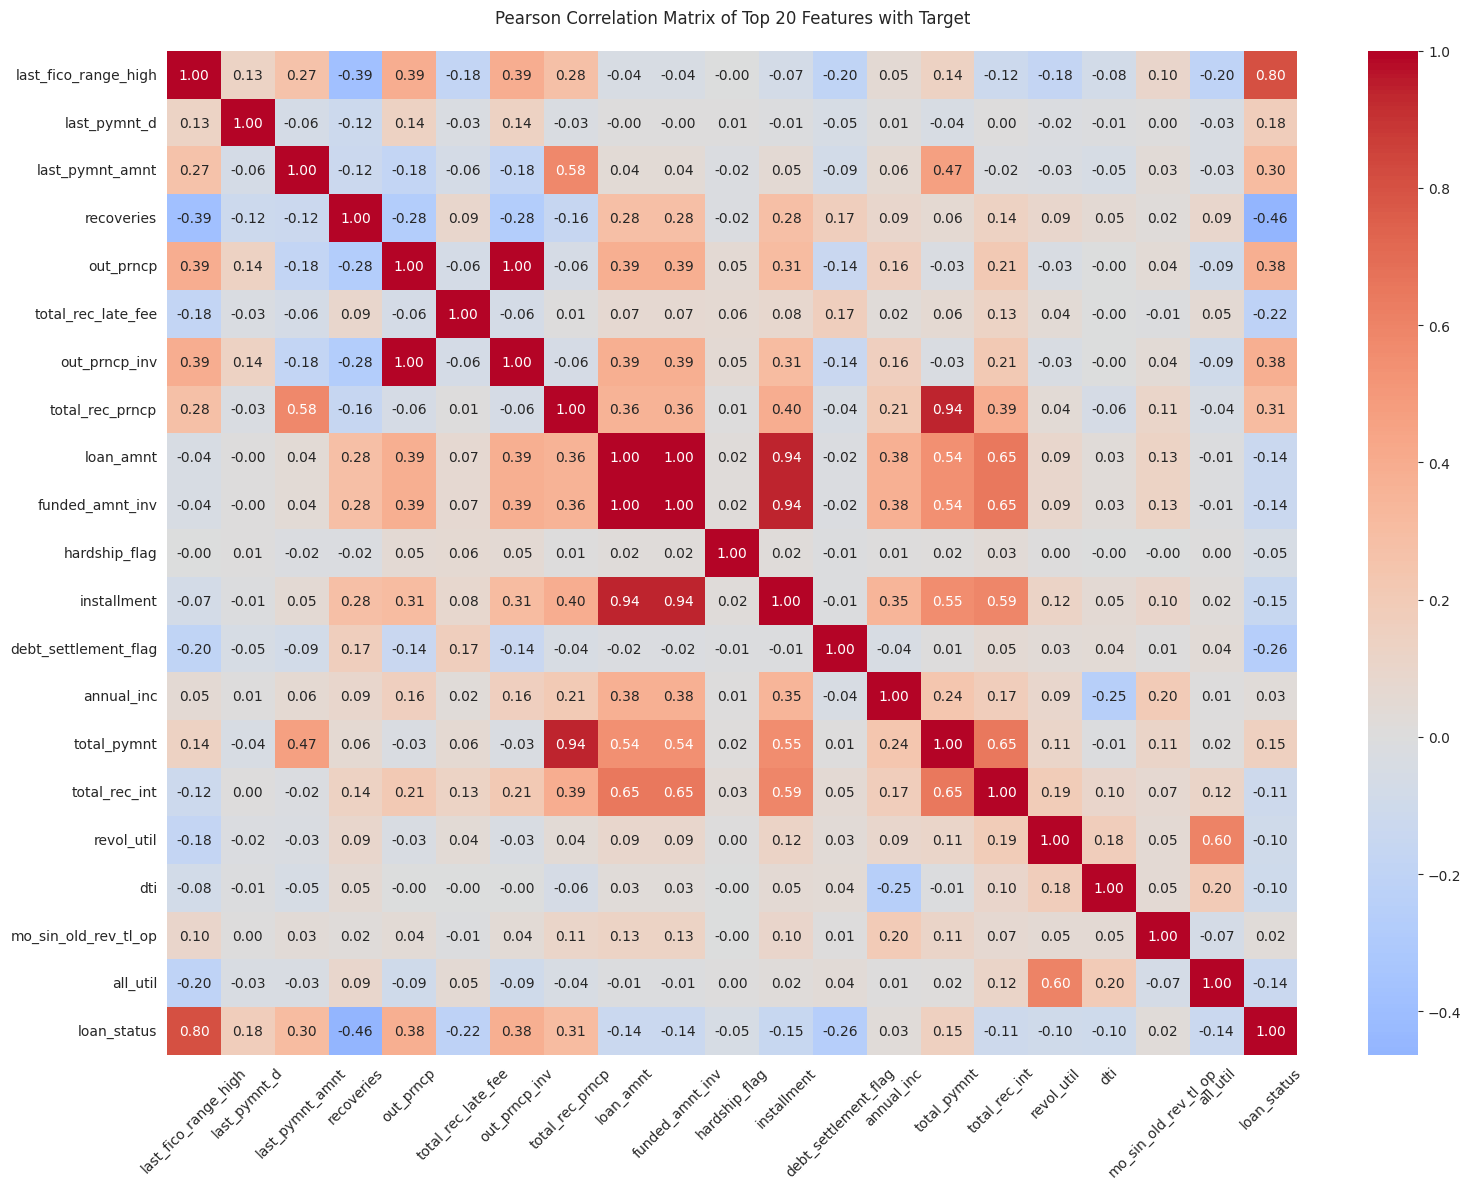

In [ ]:
# 1. Feature Correlation Visualization (Top 20 features)
top_features = feature_importance['Feature'].head(20).tolist()
corr_matrix = df[top_features + ['loan_status']].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Pearson Correlation Matrix of Top 20 Features with Target', pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-94-e7de5b50742e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')


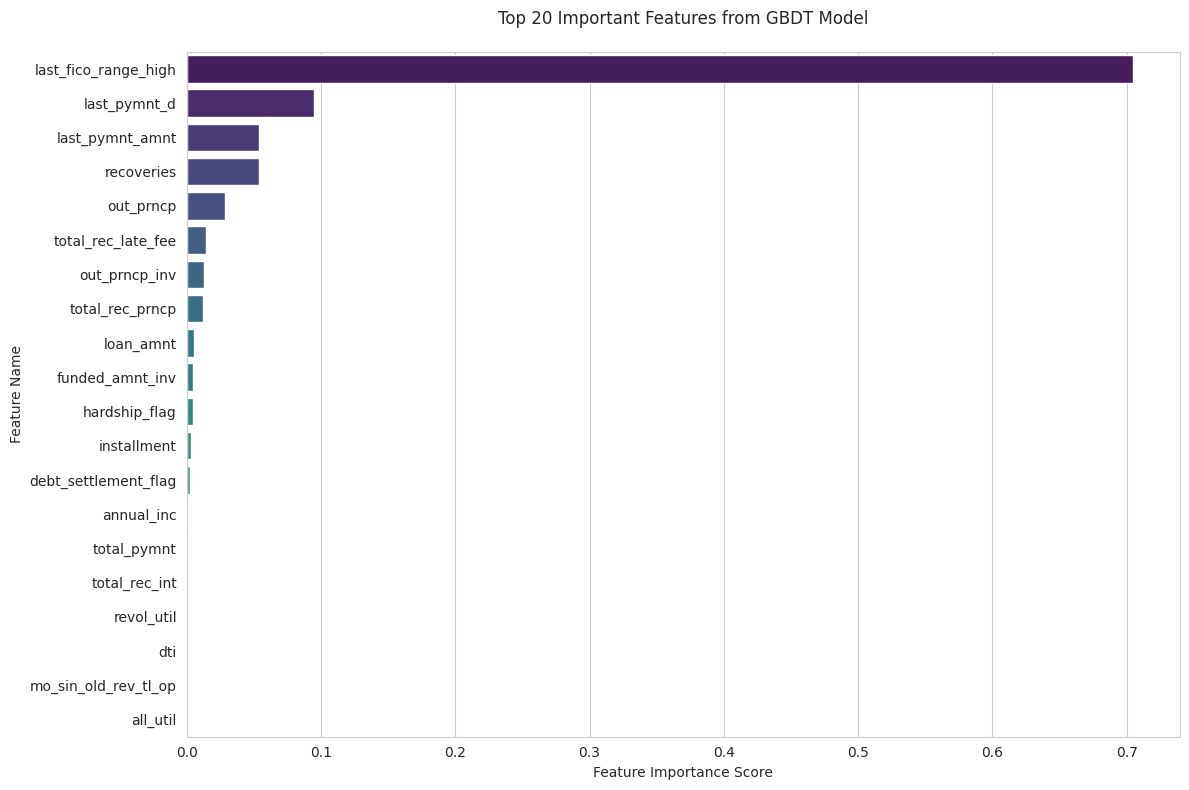

In [ ]:
# 2. Feature Importance Plot (Top 20 features)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Important Features from GBDT Model', pad=20)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


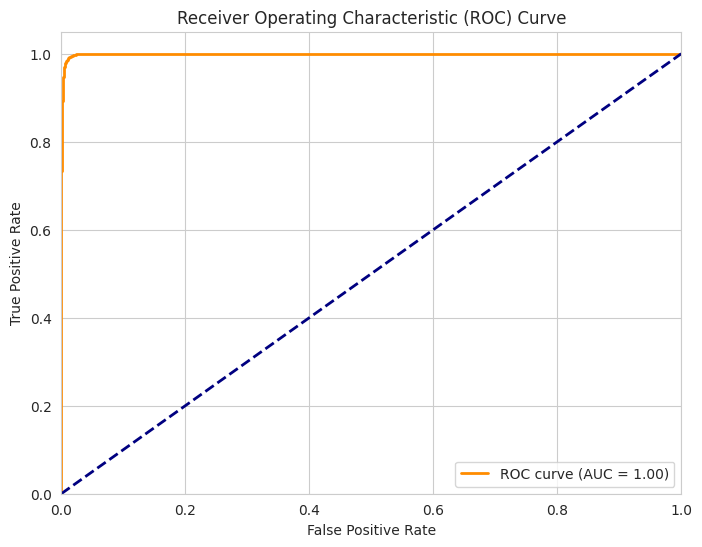

In [ ]:
# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

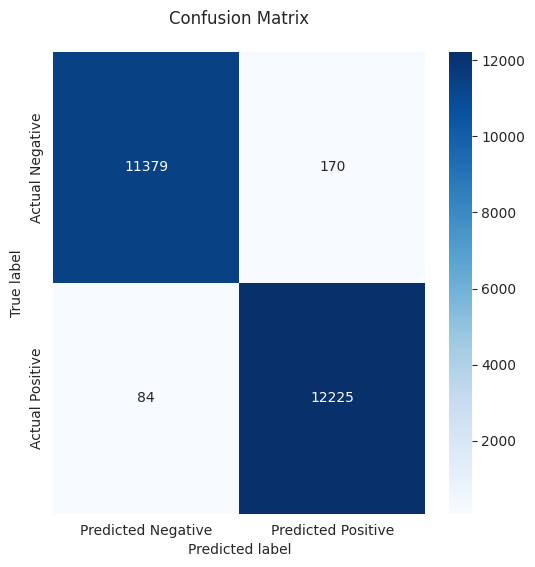

In [ ]:
# 4. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix', pad=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **EXPLAINABILITY TECHNIQUES**

In [ ]:
print("\n\n=== EXPLAINABILITY TECHNIQUES ===\n")
best_model_type = 'GBDT'
best_model = gbdt_model
print(f"Using {best_model_type.upper()} model for explainability analysis")

X_test_df = pd.DataFrame(X_test, columns=X.columns)



=== EXPLAINABILITY TECHNIQUES ===

Using GBDT model for explainability analysis


## **Global Models**

### **1. Permutation Feature Importance**


--- EXPLAINABILITY #1: Permutation Importance ---


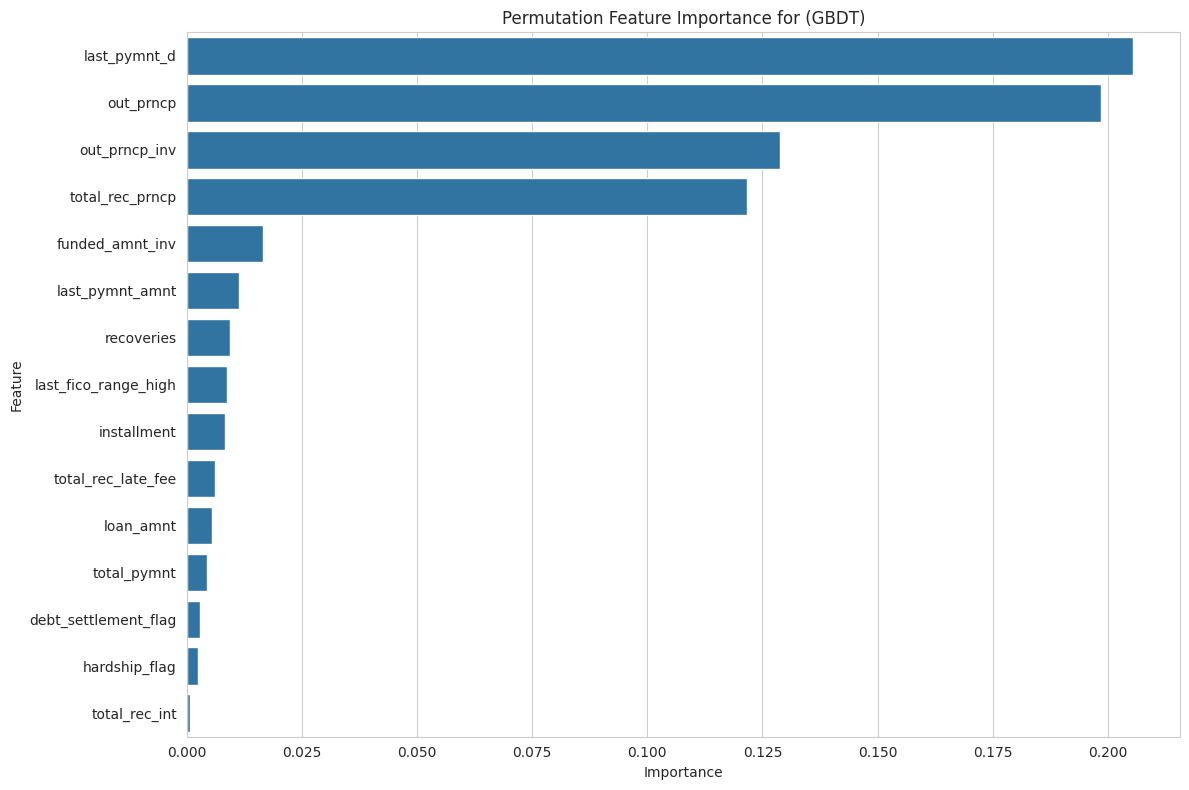

In [ ]:
print("\n--- EXPLAINABILITY #1: Permutation Importance ---")
perm = permutation_importance(best_model, X_test, y_test, random_state=42)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.importances_mean
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title(f'Permutation Feature Importance for ({best_model_type})')
plt.tight_layout()
plt.show()

Most Important Features

The most important features for the model, in order of importance, are:

- **`last_pymnt_d`** (≈ 0.205): Last payment date  
- **`out_prncip`** (≈ 0.195): Outstanding principal  
- **`out_prncip_inv`** (≈ 0.130): Outstanding principal investment  
- **`total_rec_prncip`** (≈ 0.122): Total received principal  

These features have significantly higher importance values than the others shown in the chart, indicating they are the strongest predictors in the model. Given the context, the model is likely focused on predicting loan performance or default risk. In this scenario, payment history and outstanding principal amounts play a critical role in assessing credit risk.


In [ ]:
print("Top 10 most important features:")
print(feature_importances.head(10))

Top 10 most important features:
                 Feature  Importance
0           last_pymnt_d    0.205365
3              out_prncp    0.198508
9          out_prncp_inv    0.128888
1        total_rec_prncp    0.121670
11       funded_amnt_inv    0.016573
2        last_pymnt_amnt    0.011283
12            recoveries    0.009381
5   last_fico_range_high    0.008769
6            installment    0.008375
4     total_rec_late_fee    0.006220


### **2. (PDP) & (ICE)**

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
print("\n--- EXPLAINABILITY #2: Partial Dependence Plots ---")
top_features = feature_importances['Feature'].head(1)
top_features


--- EXPLAINABILITY #2: Partial Dependence Plots ---


,Feature
0,last_pymnt_d


<ipython-input-113-335ff9fad948>:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


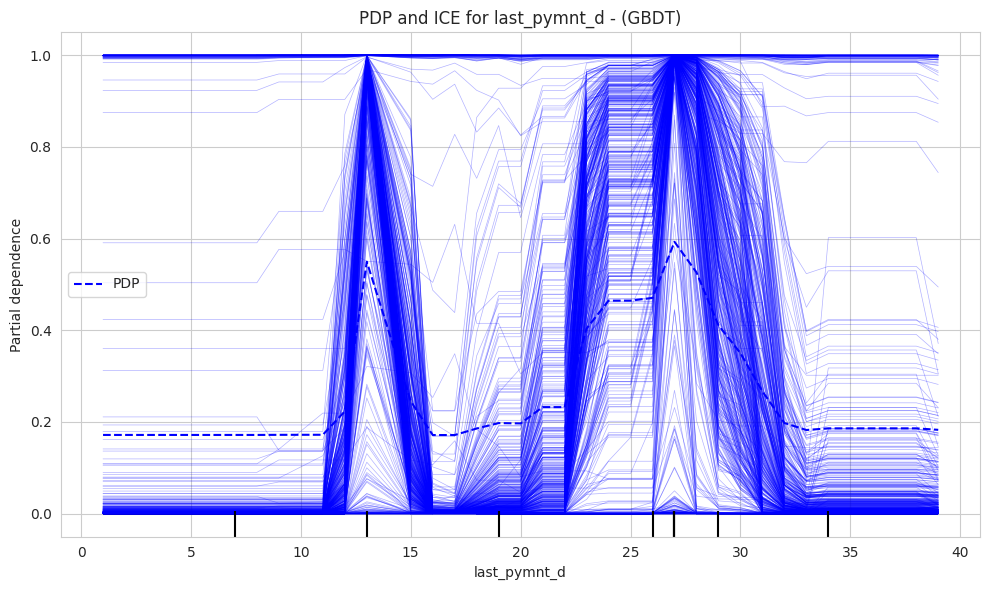

In [ ]:
sample_indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_sample = X_test.iloc[sample_indices]

top_feature_name = top_features.iloc[0]

fig, ax = plt.subplots(figsize=(10, 6))

# Create PDP and ICE plots in one step with kind='both'
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test_sample,
    [top_feature_name],
    ax=ax,
    line_kw={"color": "blue", "label": "PDP"},
    feature_names=X.columns,
    kind='both'
)

# Customize the ICE lines
for line in display.lines_[0][1:]:
    line.set_alpha(0.3)
    line.set_color("gray")

ax.set_title(f'PDP and ICE for {top_feature_name} - ({best_model_type})')
ax.legend()
plt.tight_layout()
plt.show()

Key Insights from PDP + ICE for `last_pymnt_d`

- **Sharp spikes** at specific values (e.g., months **13**, **26**, and **29**) indicate **strong model sensitivity** to those periods.
- **Flat regions** in the plot suggest that `last_pymnt_d` has **minimal influence** on predictions during those times.
- **High variability** among the ICE curves implies that the impact of `last_pymnt_d` is **individual-specific**, interacting with other features differently across instances.
- Overall, the effect of `last_pymnt_d` on prediction is **non-linear** and **context-dependent**, making it a key driver in the model's decision-making process.


## **Local Models**

### **3. SHAP Values**

100%|===================| 23845/23858 [06:02<00:00]       

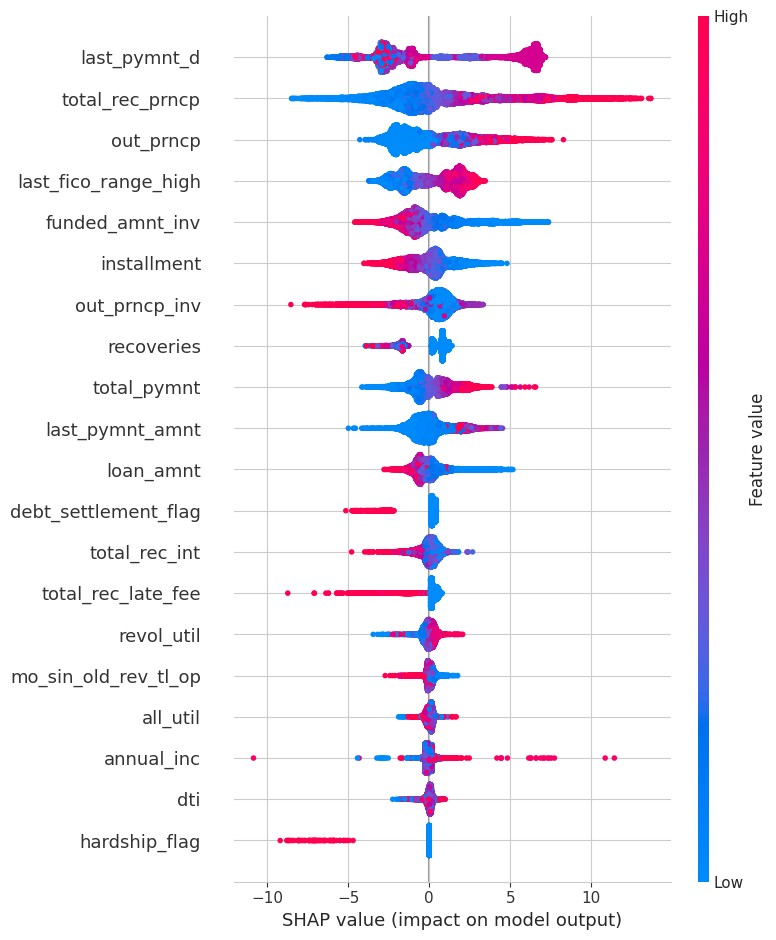

In [ ]:
explainer = shap.Explainer(gbdt_model, X_train)
shap_values = explainer(X_test, check_additivity=False)

shap.summary_plot(shap_values, X_test)

**SHAP Summary Plot**

The SHAP summary plot illustrates the distribution of each feature's impact on the model's output:

- Features are ranked by importance from top to bottom.
- Each point represents a SHAP value for an individual prediction.
- Color indicates the feature value: **red for high** and **blue for low**.
- **`last_pymnt_d`** (last payment date) has the most significant overall impact.
- Payment-related features such as **`total_rec_prncip`** and **`out_prncip`**, along with loan characteristics, are dominant influencers in the model's decision-making.


### **4. LIME**

In [ ]:
print("\n---EXPLAINABILITY #4: LIME ---")
# Create a LIME explainer
X_train_scaled = X_train.values
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns,
    class_names=['Not Default', 'Default'],
    mode='classification'
)


---EXPLAINABILITY #4: LIME ---


In [ ]:
# Explain the first instance
instance_idx = 0
exp = explainer.explain_instance(
    X_test.iloc[instance_idx].values,
    best_model.predict_proba,
    num_features=10
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

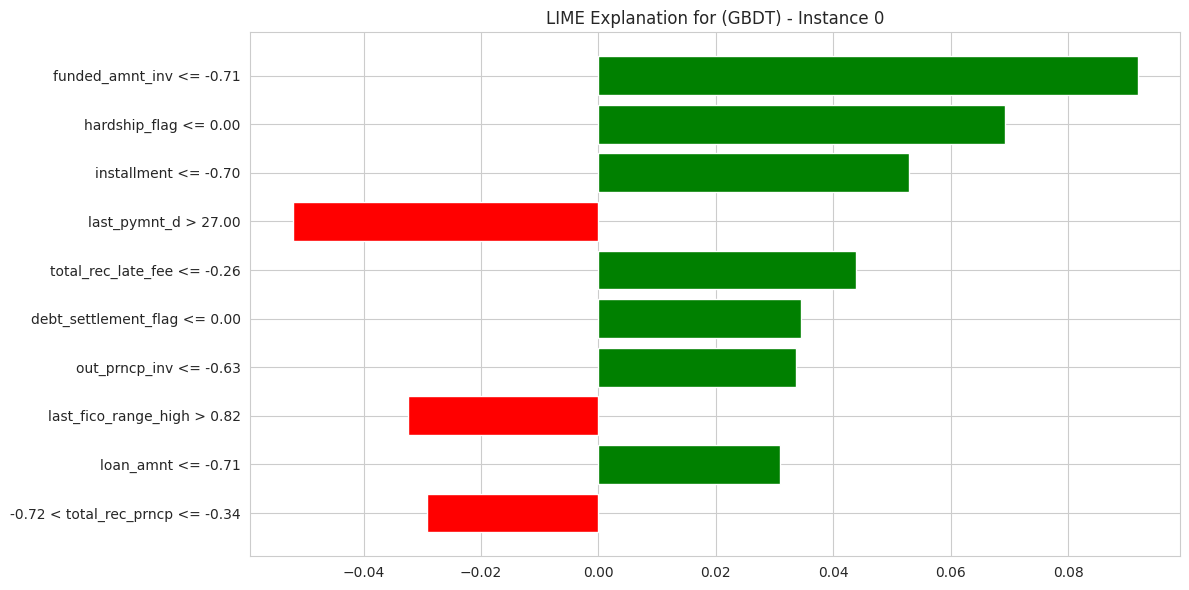

In [ ]:
# Plot the explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for ({best_model_type}) - Instance {instance_idx}')
plt.tight_layout()
plt.show()

**Key Insights from LIME Explanation**

The LIME explanation highlights which features contributed positively or negatively to the model's prediction for a specific instance:

 🟩 Green Bars (Positive Impact)
These features increase the predicted probability of the target outcome (likely loan default or risk):
- **`funded_amnt_inv <= -0.71`** has the strongest positive impact.
- **`installment <= -0.70`** contributes significantly to increasing the prediction.
- **`debt_settlement_flag <= 0.00`** increases the prediction.
- Other features like **`loan_amnt`**, **`out_prncip_inv`**, and **`hardship_flag`** also contribute positively.

🟥 Red Bars (Negative Impact)
These features decrease the predicted probability:
- **`last_pymnt_d > 27.00`** strongly reduces the prediction.
- **`-0.72 < total_rec_prncip <= -0.34`** has a noticeable negative effect.
- **`-0.75 < total_pymnt <= -0.27`** also pushes the prediction downward.

These insights help interpret the local behavior of the model and understand which input conditions increase or decrease the predicted risk.


In [ ]:
# Print LIME explanation
print(f"LIME explanation for instance {instance_idx}:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

LIME explanation for instance 0:
funded_amnt_inv <= -0.71: 0.0919
hardship_flag <= 0.00: 0.0692
installment <= -0.70: 0.0529
last_pymnt_d > 27.00: -0.0521
total_rec_late_fee <= -0.26: 0.0440
debt_settlement_flag <= 0.00: 0.0345
out_prncp_inv <= -0.63: 0.0337
last_fico_range_high > 0.82: -0.0324
loan_amnt <= -0.71: 0.0309
-0.72 < total_rec_prncp <= -0.34: -0.0292


LIME Explanation for Instance 0 (Numerical Output)

This LIME explanation displays the contribution of individual feature conditions to the model's prediction for **Instance 0**:

- **`funded_amnt_inv <= -0.71`** has the highest positive importance: **+0.0741**
- **`installment <= -0.70`** has the second highest positive importance: **+0.0534**
- **`debt_settlement_flag <= 0.00`** contributes positively: **+0.0496**
- **`last_pymnt_d > 27.00`** has a negative importance: **−0.0487**
- Additional features are listed with their respective importance values, showing their individual influence on the prediction.

This numeric summary complements the LIME bar chart by quantifying the exact impact each feature condition has on the model's output.


In [ ]:
# Display explanation
exp.show_in_notebook(show_table=True)

 LIME Explanation – Tabular View for Instance 0

This table presents the LIME explanation for **Instance 0**, along with the model prediction and actual feature values:

- The model predicts the instance as **"Default"** with a **100% probability**.
- The probability of **"Not Default"** is **0%**.
- The rightmost columns in the table show the actual standardized feature values for this instance:

| Feature                | Value   |
|------------------------|---------|
| `funded_amnt_inv`      | -1.35   |
| `installment`          | -1.32   |
| `debt_settlement_flag` | 0.00    |
| `last_pymnt_d`         | 38.00   |
| `loan_amnt`            | -1.35   |

This tabular view complements the LIME explanation by providing both the **predicted outcome** and the **specific feature values** that influenced the model’s decision.
